# Training

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

# GPUのメモリの空き容量分だけ使用
from keras import backend as K
if 'tensorflow' == K.backend():
    import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
set_session(session)

Using TensorFlow backend.
/home/kiuchi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kiuchi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kiuchi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kiuchi/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
args = {
    "train": [
        {"video": "/mnt/storage/home/kiuchi/BBT/bbt-01-06.ts", "timesheet": "/mnt/storage/home/kiuchi/BBT/bbt-01-06-timesheet.csv"},
        {"video": "/mnt/storage/home/kiuchi/BBT/bbt-01-07.ts", "timesheet": "/mnt/storage/home/kiuchi/BBT/bbt-01-07-timesheet.csv"},
    ],
    "epochs": 13,
    "modelpath": "/mnt/storage/home/kiuchi/BBT/bbt-01.kerasmodel",
    "labelpath": "/mnt/storage/home/kiuchi/BBT/bbt-01.keraslabel"
}

In [3]:
# ResNet50ベースの転移学習モデルの作成
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
# 事前に何クラスあるかを定義しておく(そうしないといけないんだろうか・・・)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
#opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"])
opt = Adam()
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

/home/kiuchi/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



[INFO] compiling model...


Video Path: /mnt/storage/home/kiuchi/BBT/bbt-01-06.ts
Video Info: 1440.0 1080.0 54537.0 29.97002997002997
0
3630
[INFO] training head...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/13
42/42 [==============================] - 25s 596ms/step - loss: 0.5474 - accuracy: 0.8435 - val_loss: 0.1394 - val_accuracy: 0.8728
Epoch 2/13
42/42 [==============================] - 20s 469ms/step - loss: 0.1270 - accuracy: 0.9545 - val_loss: 0.3214 - val_accuracy: 0.8996
Epoch 3/13
42/42 [==============================] - 20s 471ms/step - loss: 0.1022 - accuracy: 0.9616 - val_loss: 0.4163 - val_accuracy: 0.8248
Epoch 4/13
42/42 [==============================] - 20s 468ms/step - loss: 0.0583 - accuracy: 0.9793 - val_loss: 0.4384 - val_accuracy: 0.9219
Epoch 5/13
42/42 [==============================] - 20s 467ms/step - loss: 0.0476 - accuracy: 0.9842 - val_loss: 0.2931 - val_accuracy: 0.8785
Epoch 6/13
42/42 [==============================] - 2

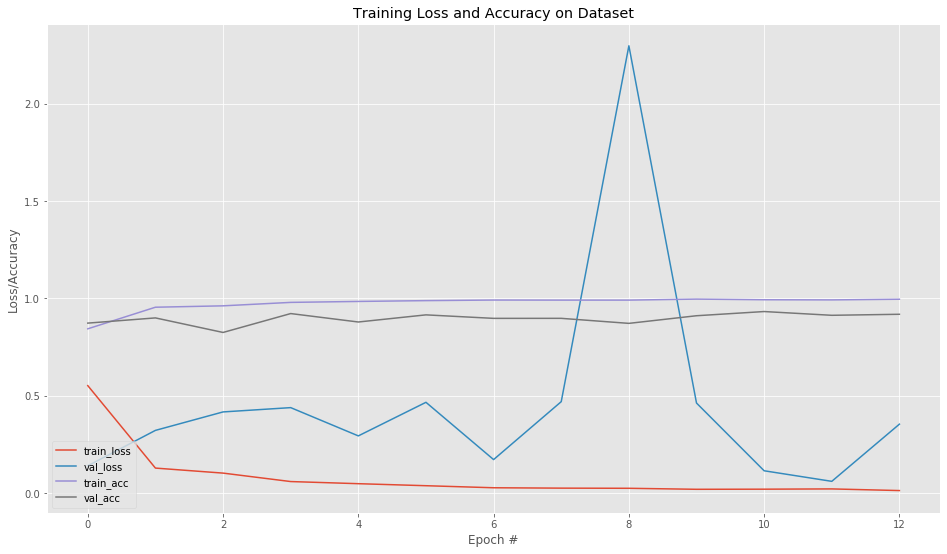

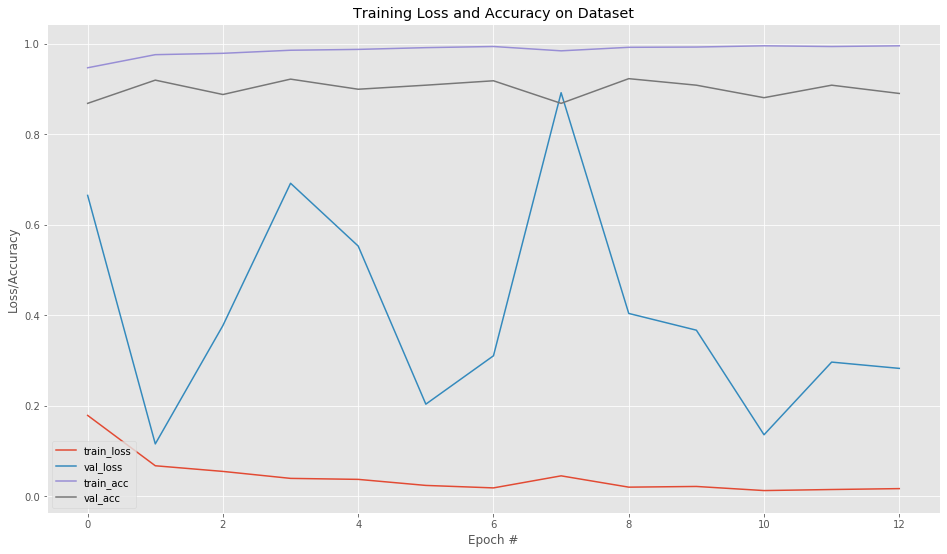

In [4]:
%matplotlib inline

def genTrainData(traindata, labeldata, video_path, tpf, timesheet):
    tdat = traindata
    ldat = labeldata
    mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
    tv = cv2.VideoCapture(video_path)
    cnt = float(0)
    pcnt = cnt
    while True:
        (grabbed, frame) = tv.read()
        if not grabbed:
            break
        label = timesheet[(timesheet["stime"] <= cnt) & (cnt < timesheet["etime"])]["type"].values
        cnt += tpf
        # ラベルを発見できて、前回のデータ採用から1秒以上経過していたら教師データに追加
        # 【備忘】1秒はチューニング要素だと思うのであとでパラメータ化する
        if len(label)>0 and (cnt - pcnt)>0.5:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224)).astype("float32")
            frame -= mean
            label = int(label[0])
            tdat.append(frame)
            ldat.append(label)
            pcnt = cnt
    return (tdat, ldat)

for t in args["train"]:
    tdat = []
    ldat = []
    # トレーニング情報のビデオとタイムシートのセットを取得
    # それぞれのファイルパスを取得
    tv_path = t["video"]
    tt_path = t["timesheet"]
    
    # タイムシートをオープン
    tt = pd.read_csv(tt_path)
    tts = tt["start"].str.extract('(?P<sh>\d+):(?P<sm>\d+):(?P<ss>\d+).(?P<sss>\d+)', expand=True)
    tte = tt["end"].str.extract('(?P<eh>\d+):(?P<em>\d+):(?P<es>\d+).(?P<ess>\d+)', expand=True)
    tt = pd.concat([tts, tte, tt["type"]], axis=1)
    tt["stime"] = tt["sh"].astype(float)*60*60 + tt["sm"].astype(float)*60 + tt["ss"].astype(float) + tt["sss"].astype(float)/1000
    tt["etime"] = tt["eh"].astype(float)*60*60 + tt["em"].astype(float)*60 + tt["es"].astype(float) + tt["ess"].astype(float)/1000
    tt = tt.drop(["sh", "sm", "ss", "sss", "eh", "em", "es", "ess"], axis=1)
    #print(tt)
    
    # ビデオをオープン
    tv = cv2.VideoCapture(tv_path)
    # ビデオの基礎情報(高さ, 幅, 総フレーム数, FramePerSecond)を取得
    tv_width = tv.get(cv2.CAP_PROP_FRAME_WIDTH);
    tv_height = tv.get(cv2.CAP_PROP_FRAME_HEIGHT);
    tv_frames = tv.get(cv2.CAP_PROP_FRAME_COUNT);
    tv_fps = tv.get(cv2.CAP_PROP_FPS);
    tv.release()
    print("Video Path:", tv_path)
    print("Video Info:", tv_width, tv_height, tv_frames, tv_fps)
    tpf = float(1/tv_fps)
    #print(tpf)
    
    # 教師データ生成
    print(len(tdat))
    (tdat, ldat) = genTrainData(tdat, ldat, tv_path, tpf, tt)
    print(len(tdat))
    data = np.array(tdat)
    labels = np.array(ldat)
    #print(data, len(labels))

    # ワンホットコーディング
    # perform one-hot encoding on the labels
    #lb = LabelBinarizer()
    #labels = lb.fit_transform(labels)
    ##print(labels)
    labels = to_categorical(labels)

    # トレーニングとテストデータに分割
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
        test_size=0.25, stratify=labels, random_state=42)

    # データセットを使ってトレーニング
    # train the head of the network for a few epochs (all other layers
    # are frozen) -- this will allow the new FC layers to start to become
    # initialized with actual "learned" values versus pure random
    print("[INFO] training head...")
    trainAug = ImageDataGenerator()
    valAug = ImageDataGenerator()
    mean = np.array([123.68, 116.779, 103.939], dtype="float32")
    trainAug.mean = mean
    valAug.mean = mean

    H = model.fit_generator(
        trainAug.flow(trainX, trainY, batch_size=64),
        steps_per_epoch=len(trainX) // 64,
        validation_data=valAug.flow(testX, testY),
        validation_steps=len(testX) // 64,
        epochs=args["epochs"])
    
    # テスト用データセットでモデルを評価
    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=64)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=["main", "cm"]))
    
    # plot the training loss and accuracy
    N = args["epochs"]
    plt.style.use("ggplot")
    plt.figure(figsize=(16,9))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    # モデルとラベルデータを保存
    # serialize the model to disk
    print("[INFO] serializing network...")
    model.save(args["modelpath"])

    # serialize the label binarizer to disk
    f = open(args["labelpath"], "wb")
    f.write(pickle.dumps(labels))
    f.close()